# Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from pymonntorch import *
import torch
import random
import math

# Time Resolution

In [6]:
class TimeResolution(Behavior) : 

    def initialize(self, net) : 
        net.dt = self.parameter("dt", 1)

# InputCurrent

In [7]:
class CurrentBehavior(Behavior) : 
    
    def initialize(self, neuron) :
        super().initialize(neuron)
        
        neuron.I = neuron.vector("zeros")
        
        self.pw = self.parameter("pw", 20)
        self.has_noise = self.parameter("has_noise", False)
        self.mode = self.parameter("mode", "constant")
        self.iter = 1
        self.func = self.parameter("custom", None)
        
        if(self.mode == "constant") : 
            def constant_curr(cnt) : 
                tp = random.random() < 0.5
                x = 1
                if(tp) : 
                    x *= -1

                return (cnt > 0) * (self.pw + self.has_noise * (random.random() * self.pw - self.pw/2 * x) / 2)
            
            self.func = constant_curr
        
        elif(self.mode == "trigeometric") : 
            def trigeometric_curr(cnt) : 
                return (math.sin(cnt/360 * np.pi))**2 * self.pw + self.has_noise * (random.random() * self.pw - random.random() * 1.5*self.pw)
            
            self.func = trigeometric_curr

        elif(self.mode == "random") : 
            def random_curr(cnt) : 
                a, res, state = np.random.rand(5) * self.pw, 0, 1
                for i in a : 
                    res += state * i
                    state *= -1
                return res
            
            self.func = random_curr
        
        elif(self.mode == "step") : 
            def step_curr(cnt) : 
                tp = random.random() < 0.5
                x = 1
                if(tp) : 
                    x *= -1

                return ((cnt > 1 and cnt < 40)) * (self.pw + self.has_noise * (random.random() * self.pw - self.pw/2 * x) / 2)
            
            self.func = step_curr

        elif(self.mode == "stair") : 
            def stair(cnt) : 
                return neuron.I + self.pw
            
            self.func = stair

        elif(self.mode == "change") : 
            def ch(cnt) : 
                tp = random.random() < 0.5
                x = 1
                if(tp) : 
                    x *= -1

                return (cnt > 0) * (self.pw + self.has_noise * (random.random() * self.pw/8 - self.pw/16 * x) / 2) + (cnt > 50) * (self.pw / 2) 
            self.func = ch

        elif(self.mode == "change2") : 
            def ch2(cnt) : 
                tp = random.random() < 0.5
                x = 1
                if(tp) : 
                    x *= -1

                return (cnt > 1) * (self.pw + self.has_noise * (random.random() * self.pw/8 - self.pw/16 * x) / 2) - (cnt > 100) * (self.pw / (0.01 + 201 - cnt)) 
            self.func = ch2

        elif(self.mode == "swap1") : 
            def ch(cnt) : 
                tp = random.random() < 0.5
                x = 1
                if(tp) : 
                    x *= -1

                res = (cnt > 0) * (self.pw + self.has_noise * (random.random() * self.pw/8 - self.pw/16 * x) / 2) + (cnt > 50 and cnt < 100) * (self.pw / 2) 
                return res
            self.func = ch

        elif(self.mode == "swap2") : 
            def ch(cnt) : 
                tp = random.random() < 0.5
                x = 1
                if(tp) : 
                    x *= -1

                res = (cnt > 0) * (self.pw + self.has_noise * (random.random() * self.pw/8 - self.pw/16 * x) / 2) + (cnt > 120) * (self.pw / 2) 
                return res
                
            self.func = ch

        else :
            self.func = self.parameter("custom", None)


    def forward(self, neuron) : 
        neuron.I += (self.func(self.iter))
        self.iter += 1

# LIF

In [837]:
class LIF_Behavior(Behavior) :

    def initialize(self, ng) : 
        super().initialize(ng)

        self.threshold = self.parameter("threshold", -10)
        self.reset = self.parameter("reset", -80)
        self.rest = self.parameter("rest", -65)
        self.tau = self.parameter("tau", 10)
        self.dt = self.parameter("dt", 1)
        self.R = self.parameter("R", 10)

        ng.voltage = ng.vector("normal(-60, 120)")

        firing = ng.voltage >= self.threshold
        ng.spike = firing.byte()
        ng.voltage[firing] = self.reset

        ng.activity = ng.vector(torch.sum(ng.spike).item()) / ng.size


    def forward(self, ng) : 
        firing = ng.voltage >= self.threshold
        ng.spike = firing.byte()
        ng.voltage[firing] = self.reset

        dV = (-(ng.voltage - self.rest) + self.R * ng.I) / self.tau 
        ng.voltage += dV * self.dt

        ng.activity = ng.vector(torch.sum(ng.spike).item()) / ng.size
        

# Synapses

In [340]:
class SynFun(Behavior) : 

    def initialize(self, sg) : 
        sg.I = sg.dst.vector()

    def forward(self, sg) :
        # print(sg.src.spike)
        sg.I = torch.sum(sg.W[sg.src.spike], axis = 0)

In [341]:
class SynInp(Behavior) : 
    
    def forward(self, ng) : 
        for syn in ng.afferent_synapses["All"] : 
            ng.I += syn.I

In [862]:
class SynTypeInput(Behavior) : 

    def initialize(self, ng) : 
        self.decay = self.parameter("decay", 0.4)
        ng.I = ng.vector()

    def forward(self, ng) : 
        ng.I *= self.decay
        for syn in ng.afferent_synapses["GLUTAMATE"] : 
            ng.I += syn.I
        
        # for syn in ng.afferent_synapses["GABA"] : 
        #     ng.I -= syn.I

# Connectivity Scheme

In [1259]:
class SynConnectivity(Behavior) : 
    
    def initialize(self, sg) : 
        self.mode = self.parameter("mode", "full")
        self.J0 = self.parameter("J0", 50)
        self.n = sg.src.size
        self.p = self.parameter("p", 0.3)
        self.C = self.parameter("C", 20)
        
        if(self.mode == "full") : 
            sg.W = sg.matrix(self.J0 / self.n)

        elif(self.mode == "full2") : 
            sg.W = sg.matrix("normal(30, 3)")

        elif(self.mode == "full_up") : 
            sg.W = sg.matrix("normal(40, 6)")

        elif(self.mode == "full_down") : 
            sg.W = sg.matrix("normal(10, 6)")

        elif(self.mode == "inh") : 
            sg.W = sg.matrix("normal(9, 3)")    
        
        elif(self.mode == "random") : 
            sg.W = sg.matrix(self.J0 / (self.n * self.p))
            for i in range(sg.matrix_dim()[0]) : 
                for j in range(sg.matrix_dim()[1]) : 
                    q = random.random()
                    if(q > self.p) : 
                        sg.W[i, j] = 0

        elif(self.mode == "balanced") : 
            sg.W = sg.matrix(self.J0 / math.sqrt((self.n * self.p)))
            for i in range(sg.matrix_dim()[0]) : 
                for j in range(sg.matrix_dim()[1]) : 
                    q = random.random()
                    if(q > self.p) : 
                        sg.W[i, j] = 0

        elif(self.mode == "random_fixed") :
            sg.W = sg.matrix(self.J0 / self.n)
            for i in range(sg.matrix_dim()[0]) :
                adj = torch.randperm(sg.matrix_dim()[1])
                for j in range(self.C, sg.matrix_dim()[1]) : 
                    sg.W[i, adj[j]] = 0

        elif(self.mode == "balanced_fixed") : 
            md = "normal({}, {})".format(self.J0 / math.sqrt(self.C), self.J0 / math.sqrt(self.C) / 2)
            sg.W = sg.matrix(md)
            for i in range(sg.matrix_dim()[0]) :
                adj = torch.randperm(sg.matrix_dim()[1])
                for j in range(self.C, sg.matrix_dim()[1]) : 
                    sg.W[i, adj[j]] = 0     

        elif(self.mode == "bias") : 
            sg.W = sg.matrix(0)
            for target in range(sg.matrix_dim()[1]) :
                for inp in range(sg.matrix_dim()[0]) : 
                    if(target == 0) : 
                        sg.W[inp][target] = 40 + (random.random() - 0.5) * 10
                    else :
                        sg.W[inp][target] = 5 + (random.random() - 0.5) * 10

# Data

In [13]:
from PIL import Image 

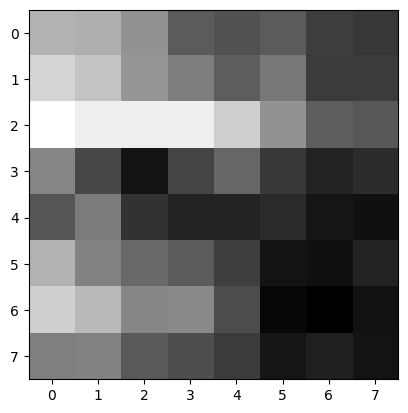

In [14]:
img = Image.open("data/bridge.tif")
img = img.resize((8, 8))
img = np.array(img)
plt.imshow(img, cmap = "gray")
plt.show()

In [15]:
img.shape

(8, 8)

In [16]:
print(img)
print("min : {}, max : {}".format(img.min(), img.max()))

[[160 157 141 110 105 110  94  90]
 [178 168 143 129 111 126  92  92]
 [202 193 192 193 175 141 111 108]
 [134  99  70  97 116  91  78  84]
 [107 128  87  79  79  83  71  68]
 [160 132 118 110  94  70  68  78]
 [175 163 134 136 102  63  59  69]
 [130 132 109 103  92  71  77  70]]
min : 59, max : 202


In [17]:
flat_img = img.flatten()
flat_img.shape

(64,)

In [18]:
def ImagePipeline(inp, show = False, shape = (32, 32)) : 
    img = Image.open(inp)
    img = img.resize(shape)
    img = np.array(img)
    if(show) : 
        plt.imshow(img, cmap = "gray")
        plt.show()
    img = img.flatten()
    img = torch.from_numpy(img)
    img = img.type(torch.int64)
    return img

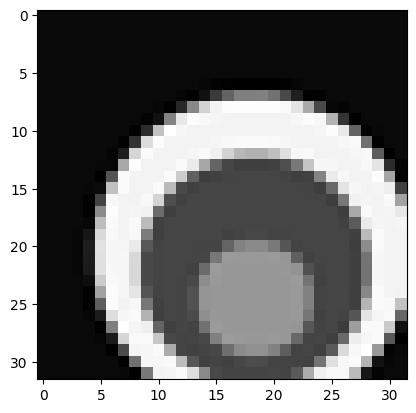

tensor([20, 20, 20,  ..., 15, 20, 20])

In [19]:
ImagePipeline("data/circles.tif", show = True)

# Encoding

## Time-to-first-spike

In [20]:
T = 10 # 10ms Time interval

In [21]:
class TTFS_Encoding(Behavior) : 
    
    def initialize(self, ng) : 

        ng.input = self.parameter("input", None)
        self.offset = self.parameter("offset", 0)
        self.T = self.parameter("T", 10)
        ng.spike = ng.vector("zeros")
        ng.spike_train = ng.vector("zeros")

    def forward(self, ng) : 

        if(ng.network.iteration - self.offset >= self.T or ng.network.iteration < self.offset) : 
            ng.spike = ng.vector("zeros")
            
        en = (255 / self.T) * (ng.network.iteration - self.offset)
        st = (255 / self.T) * (ng.network.iteration - self.offset - 1)

        ng.spike_train = ng.spike
        ng.spike = torch.logical_and(ng.input > st, ng.input <= en).byte()

## Numerical Values

In [22]:
def normal(sigma, mu, t) :
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (t - mu)**2 / (2 * sigma**2))

max is : 0.19947114020071635


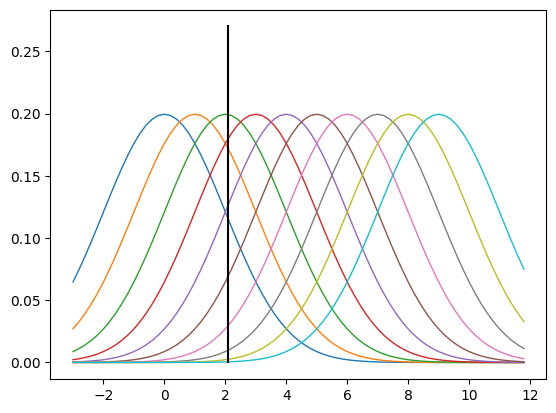

In [23]:
mu, sigma = 0, 2 # mean and standard deviation
t = np.arange(-3, +12, 0.2)
for i in range(0, 10) : 
    mu = i
    plt.plot(t, normal(sigma, mu, t), linewidth=1)


print("max is : {}".format(normal(sigma, 1, 1)))
plt.plot([2.1, 2.1], [0, .27], color = "black")
plt.show()


In [24]:
df = np.array([1, 2, 2.45, 4.44, 6.71, 7.23]) # 6 ta

In [25]:
def NumericValueEncoder(img) : 
    code = np.ndarray((len(img), 10))
    for i in range(len(img)) :
        for j in range(10) : 
            code[i][j] = round(normal(1.5, j, img[i]), 2)
    return code

In [26]:
NumericValueEncoder(df)

array([[0.21, 0.27, 0.21, 0.11, 0.04, 0.01, 0.  , 0.  , 0.  , 0.  ],
       [0.11, 0.21, 0.27, 0.21, 0.11, 0.04, 0.01, 0.  , 0.  , 0.  ],
       [0.07, 0.17, 0.25, 0.25, 0.16, 0.06, 0.02, 0.  , 0.  , 0.  ],
       [0.  , 0.02, 0.07, 0.17, 0.25, 0.25, 0.15, 0.06, 0.02, 0.  ],
       [0.  , 0.  , 0.  , 0.01, 0.05, 0.14, 0.24, 0.26, 0.18, 0.08],
       [0.  , 0.  , 0.  , 0.  , 0.03, 0.09, 0.19, 0.26, 0.23, 0.13]])

In [27]:
class NumericalValueEncoding(Behavior) : 

    def initialize(self, ng) : 
        self.input = self.parameter("input", 5)
        self.offset = self.parameter("offset", 0)
        self.sigma = self.parameter("sigma", 2.5)
        self.T = self.parameter("T", 40)

        self.mx = self.normal(self.sigma, 1, 1)

        ng.input = ng.vector("zeros")
        ng.spike = ng.vector("zeros")

        for i in range(ng.size) : 
            ng.input[i] = self.T - int(self.normal(self.sigma, i, self.input) / self.mx * self.T)
        
        for i in range(ng.size) : 
            print(ng.input[i], end=" ")
        print()

    def forward(self, ng) : 
        ng.spike = ng.vector("zeros")
        ng.spike[ng.network.iteration == ng.input] = 1
        
    def normal(self, sigma, mu, t) :
        return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (t - mu)**2 / (2 * sigma**2))

In [28]:
net = Network(behavior={1 : TimeResolution(dt = 1)})

inputLayer = NeuronGroup(net = net, size = 256, behavior={
    2 : TTFS_Encoding(input = ImagePipeline("data/bridge.tif", shape = (8, 8)), T = 40),
    # 3 : CurrentBehavior(mode = "random", pw = 3),
    # 7 : Trace(),
    
    10 : EventRecorder(['spike']) 
})


In [29]:
net = Network(behavior={1 : TimeResolution(dt = 1)})

inputLayer = NeuronGroup(net = net, size = 256, behavior={
    2 : NumericalValueEncoding(input = 156.71, T = 60, sigma = 50),
    # 3 : CurrentBehavior(mode = "random", pw = 3),
    # 7 : Trace(),
    
    10 : EventRecorder(['spike']) 
})


In [30]:
net.initialize()
net.simulate_iterations(100)

Network['Network'](Neurons: tensor(256)|1 groups, Synapses: tensor(0.)|0 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](256){2:NumericalValueEncoding(input=156.71,T=60,sigma=50,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
tensor(60.) tensor(60.) tensor(60.) tensor(60.) tensor(60.) tensor(60.) tensor(60.) tensor(60.) tensor(60.) tensor(60.) tensor(60.) tensor(60.) tensor(60.) tensor(60.) tensor(59.) tensor(59.) tensor(59.) tensor(59.) tensor(59.) tensor(59.) tensor(59.) tensor(59.) tensor(59.) tensor(59.) tensor(59.) tensor(59.) tensor(59.) tensor(58.) tensor(58.) tensor(58.) tensor(58.) tensor(58.) tensor(58.) tensor(58.) tensor(58.) tensor(57.) tensor(57.) tensor(57.) tensor(57.) tensor(57.) tensor(57.) tensor(56.) tensor(56.) tensor(56.) tensor(56.) tensor(56.) tensor(55.) tensor(55.) tensor(55.) tensor(55.) tensor(54.) tensor(54.) tensor(54.) tensor(54.) tensor(53.) tensor(53.) tensor(

27.046680450439453

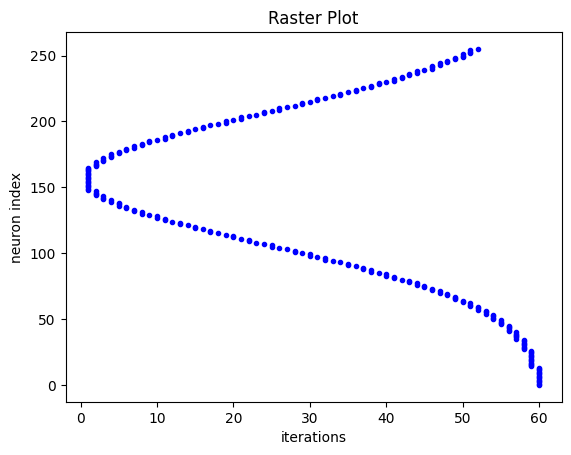

In [31]:
# plt.figure(figsize = (6, 2))

plt.plot(inputLayer['spike.t', 0], inputLayer['spike.i', 0], '.', color = "blue")
plt.xlabel('iterations')
plt.ylabel('neuron index')
plt.title('Raster Plot')
plt.show()

## Poission 

In [32]:
b = torch.tensor([157, 158, 161])
b.dtype
1 - torch.exp(b * -1 * 0.005)

tensor([0.5439, 0.5462, 0.5529])

In [33]:
a = ImagePipeline("data/camera.tif")
print(a)
print(torch.exp(a * -1 * 0.01))
1 - torch.exp(a * -1 * 0.01)

tensor([157, 158, 161,  ..., 117, 115, 115])
tensor([0.2080, 0.2060, 0.1999,  ..., 0.3104, 0.3166, 0.3166])


tensor([0.7920, 0.7940, 0.8001,  ..., 0.6896, 0.6834, 0.6834])

In [34]:
class PoissionGenerator(Behavior) :

    def initialize(self, ng) : 
        self.offset = self.parameter("offset", [0])
        self.T = self.parameter("T", [40])
        self.lamda = self.parameter("lamda", [20])

        ng.spike_train = ng.vector("zeros")
        ng.spike = ng.vector("zeros")
        self.poisson = 0

        # ng.poisson = (1 - torch.exp(ng.input * -1 * self.lamda))

    def forward(self, ng) : 

        pat = self.pattern(ng)
        
        if(pat == -1) : 
            ng.spike_train = ng.spike
            ng.spike = torch.rand(ng.size) <= 0
        else :
            self.poisson = (np.exp(-self.lamda[pat]) * (self.lamda[pat] ** (ng.network.iteration - self.offset[pat]))) / (np.math.factorial(ng.network.iteration - self.offset[pat])) / ((np.exp(-self.lamda[pat]) * (self.lamda[pat] ** self.lamda[pat])) / (np.math.factorial(self.lamda[pat]))*2)
            ng.spike_train = ng.spike
            ng.spike = torch.rand(ng.size) <= self.poisson

    def pattern(self, ng) : 
        for i in range(len(self.offset)) : 
            if(ng.network.iteration >= self.offset[i] and ng.network.iteration - self.offset[i] <= self.T[i]) : 
                return i
        return -1

In [35]:
def fact(x) : 
    res = 1
    for i in range(1, x + 1) : 
        res *= i
    return res

In [36]:
def pois(x, lam = 5) : 
    return (np.exp(-lam) * (lam ** x)) / (np.math.factorial(x))

In [37]:
class PoissionEncoding(Behavior) :

    def initialize(self, ng) : 
        ng.input = self.parameter("input", None, required = True)
        self.offset = self.parameter("offset", 0)
        self.T = self.parameter("T", 10)
        self.lamda = self.parameter("lamda", 0.005)

        ng.spike_train = ng.vector("zeros")
        ng.spike = ng.vector("zeros")

        ng.poisson = (1 - torch.exp(ng.input * -1 * self.lamda))

    def forward(self, ng) : 
        
        if(ng.network.iteration - self.offset >= self.T or ng.network.iteration < self.offset) : 
            ng.spike_train = ng.spike
            ng.spike = torch.rand(ng.size) <= 0
        else :
            ng.spike_train = ng.spike
            ng.spike = torch.rand(ng.size) <= ng.poisson

In [38]:
net = Network(behavior={1 : TimeResolution(dt = 1)})

inputLayer = NeuronGroup(net = net, size = 100, behavior={
    2 : PoissionGenerator(T = 40, lamda = 20),
    # 3 : CurrentBehavior(mode = "random", pw = 3),
    # 7 : Trace(),
    
    10 : EventRecorder(['spike']) 
})


In [39]:
net.initialize()
net.simulate_iterations(100)

Network['Network'](Neurons: tensor(100)|1 groups, Synapses: tensor(0.)|0 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](100){2:PoissionGenerator(T=40,lamda=20,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}


TypeError: 'int' object is not subscriptable

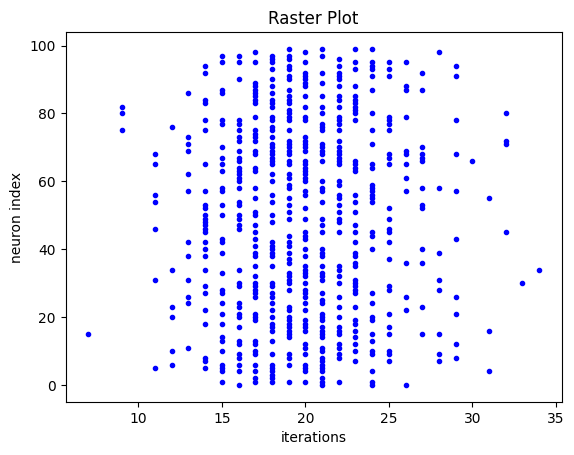

In [ ]:
# plt.figure(figsize = (6, 2))

plt.plot(inputLayer['spike.t', 0], inputLayer['spike.i', 0], '.', color = "blue")
plt.xlabel('iterations')
plt.ylabel('neuron index')
plt.title('Raster Plot')
plt.show()

# Learning

## Flat-STDP

In [40]:
class Flat_STDP(Behavior) : 

    def initialize(self, ng) :
        self.stdp_factor = self.parameter("stdp_factor", 0.015)
        self.syn_type = self.parameter("syn_type", "GLUTAMATE")
        
        ng.spike_train = ng.vector("zeros")

    def forward(self, ng) : 
        
        for syn in ng.afferent_synapses[self.syn_type] : 

            pre_post = syn.dst.spike[:, None] * syn.src.spike_train[None, :]
            post_pre = syn.dst.spike_train[:, None] * syn.src.spike[None, :]
            simu = syn.dst.spike[:, None] * syn.src.spike[None, :]


            dW_neg = self.stdp_factor * (post_pre)
            dW_pos = self.stdp_factor * (pre_post + simu)

            syn.W -= dW_neg.T
            syn.W += dW_pos.T
            syn.W = torch.clip(syn.W, 0.0, 8.0)
        
        ng.spike_train = ng.spike.clone()

In [41]:
class Trace(Behavior) : 

    def initialize(self, ng) : 
        self.trace_tau = self.parameter("trace_tau", 10)
        
        ng.x_trace = ng.vector("zeros")
        ng.y_trace = ng.vector("zeros")

    def forward(self, ng) :
        
        dX = (-1) * ng.x_trace/self.trace_tau + ng.spike
        ng.x_trace += dX * ng.network.dt

        dY = (-1) * ng.y_trace/self.trace_tau + ng.spike
        ng.y_trace += dY * ng.network.dt

In [545]:
class STDP(Behavior) :

    def initialize(self, ng) : 

        self.stdp_factor = self.parameter("stdp_factor", 0.015)
        self.syn_type = self.parameter("syn_type", "GLUTAMATE")
        self.test_phase = self.parameter("test_phase", 160)

    def forward(self, ng) : 

        if(ng.network.iteration >= self.test_phase) : 
            return
        
        for syn in ng.afferent_synapses[self.syn_type] : 

            post_pre = self.stdp_factor * syn.dst.y_trace * syn.src.spike[:, None]
            pre_post = self.stdp_factor * syn.src.x_trace[:,None] * syn.dst.spike
            dW =  (-post_pre + pre_post) * ng.network.dt

            syn.W = torch.clip(syn.W + dW, 0.0, 60.0)
            

In [455]:
class LateralInhibition(Behavior) : 

    def initialize(self, ng) : 
        self.inh_rate = self.parameter("inh_rate", 3)

    def forward(self, ng) : 
        
        inhibition = ng.vector(self.inh_rate)
        if(inhibition[ng.spike == 1].size()[0] != 0) :
            inhibition[ng.spike == 1] = 0
        else :
            inhibition = ng.vector(0)
            
        ng.I -= inhibition

In [528]:
class Bias(Behavior) : 
    
    def initialize(self, ng) : 
        self.offset = self.parameter("offset", 100)
        self.T = self.parameter("T", 10)
        self.bias = self.parameter("bias", 0.5)

        self.target = self.parameter("target", 2) - 1

    def forward(self, ng) : 
        
        if(ng.network.iteration < self.offset or ng.network.iteration > self.offset + self.T) : 
            return

        prob = random.random()
        if((prob <= self.bias)) :
            ng.spike[self.target] = 1

# Experiment (1)

In [601]:
net = Network(behavior={1 : TimeResolution(dt = 1)})

inputLayer1 = NeuronGroup(net = net, size = 4, behavior={
    # 2 : PoissionEncoding(input = ImagePipeline("data/bird.tif", shape = (2, 2)), T = 0, lamda = 0.002),
    2 : PoissionGenerator(offset = [0, 160], T = [60, 60], lamda = [30, 30]),
    3 : BackgroundActivity(),
    # 3 : CurrentBehavior(mode = "random", pw = 3),
    7 : Trace(),
    
    20 : Recorder(['x_trace','y_trace']),
    21 : EventRecorder(['spike', 'bck_spike'])
})

inputLayerMiddle = NeuronGroup(net = net, size = 0, behavior={
    # 2 : PoissionEncoding(input = ImagePipeline("data/bird.tif", shape = (2, 2)), T = 50, lamda = 0.002),   
    2 : PoissionGenerator(offset = [0, 60], T = [40, 40], lamda = [20, 20]),
    3 : BackgroundActivity(),
    # 3 : CurrentBehavior(mode = "random", pw = 3),
    7 : Trace(),

    20 : Recorder(['x_trace','y_trace']),
    21 : EventRecorder(['spike', 'bck_spike']) 
})

inputLayer2 = NeuronGroup(net = net, size = 4, behavior={
    # 2 : PoissionEncoding(input = ImagePipeline("data/bird.tif", shape = (2, 2)), T = 50, lamda = 0.002),   
    2 : PoissionGenerator(offset = [80, 250], T = [60, 60], lamda = [30, 30]),
    3 : BackgroundActivity(),
    # 3 : CurrentBehavior(mode = "random", pw = 3),
    7 : Trace(),

    20 : Recorder(['x_trace','y_trace']),
    21 : EventRecorder(['spike', 'bck_spike']) 
})


# --------------------------------- ISOLATED NEURONS --------------------------------------------------

# inputLayerIsolated = NeuronGroup(net = net, size = 1, behavior={
#     # 2 : PoissionEncoding(input = ImagePipeline("data/bird.tif", shape = (2, 2)), T = 50, lamda = 0.002),   
#     2 : PoissionGenerator(offset = [0], T = [0], lamda = [0]),
#     3 : BackgroundActivity(),
#     # 3 : CurrentBehavior(mode = "random", pw = 3),
#     7 : Trace(),

#     9 : Recorder(['x_trace','y_trace']),
#     10 : EventRecorder(['spike', 'bck_spike']) 
# })

# outputLayerIsolated = NeuronGroup(net = net, size = 1, behavior={
#     # 3 : CurrentBehavior(mode = "random", pw = 0.1),
#     4 : SynTypeInput(),
#     6 : LIF_Behavior(tau = 15, threshold = 10000),
#     7 : BackgroundActivity(0.1),
    
#     8 : Trace(),
#     9 : STDP(stdp_factor = 0.2),

#     10 : Recorder(['voltage', 'torch.mean(voltage)', 'I', 'activity', 'x_trace','y_trace']),
#     11 : EventRecorder(['spike', 'bck_spike']) 
# })


# --------------------------------- ISOLATED NEURONS --------------------------------------------------

outputLayer = NeuronGroup(net = net, size = 2, behavior={
    # 3 : CurrentBehavior(mode = "random", pw = 0.1),
    4 : SynTypeInput(),
    6 : LIF_Behavior(tau = 10),
    7 : BackgroundActivity(0.1),
    8 : Bias(target = 2, offset = 90, T = 10),
    9 : LateralInhibition(inh_rate = 180),
    
    10 : Trace(),
    11 : STDP(stdp_factor = 2),

    20 : Recorder(['voltage', 'torch.mean(voltage)', 'I', 'activity', 'x_trace','y_trace']),
    21 : EventRecorder(['spike', 'bck_spike']) 
})


syn1 = SynapseGroup(net = net, src = inputLayer1, dst = outputLayer, tag = "GLUTAMATE", behavior={
    2 : SynConnectivity(mode = "full2", J0 = 10),
    3 : SynFun(),
    9 : Recorder(['W']),
})

syn2 = SynapseGroup(net = net, src = inputLayer2, dst = outputLayer, tag = "GLUTAMATE", behavior={
    2 : SynConnectivity(mode = "full2", J0 = 10),
    3 : SynFun(),
    9 : Recorder(['W']),
})

syn3 = SynapseGroup(net = net, src = inputLayerMiddle, dst = outputLayer, tag = "GLUTAMATE", behavior={
    2 : SynConnectivity(mode = "full2", J0 = 10),
    3 : SynFun(),
    9 : Recorder(['W']),
})

# --------------------------------- ISOLATED NEURONS --------------------------------------------------

# syn1_iso = SynapseGroup(net = net, src = inputLayer1, dst = outputLayerIsolated, tag = "GLUTAMATE", behavior={
#     2 : SynConnectivity(mode = "full2", J0 = 2),
#     3 : SynFun(),
#     9 : Recorder(['W']),
# })

# syn2_iso = SynapseGroup(net = net, src = inputLayer2, dst = outputLayerIsolated, tag = "GLUTAMATE", behavior={
#     2 : SynConnectivity(mode = "full2", J0 = 2),
#     3 : SynFun()zZ,
#     9 : Recorder(['W']),
# })

# syn3_iso = SynapseGroup(net = net, src = inputLayerMiddle, dst = outputLayerIsolated, tag = "GLUTAMATE", behavior={
#     2 : SynConnectivity(mode = "full2", J0 = 2),
#     3 : SynFun(),
#     9 : Recorder(['W']),
# })

# --------------------------------- ISOLATED NEURONS --------------------------------------------------

In [602]:
net.initialize()
net.simulate_iterations(320)

Network['Network'](Neurons: tensor(10)|4 groups, Synapses: tensor(16)|3 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](4){2:PoissionGenerator(offset=[0, 160],T=[60, 60],lamda=[30, 30],)3:BackgroundActivity()7:Trace()20:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['x_trace', 'y_trace'],)21:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike', 'bck_spike'],)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](0){2:PoissionGenerator(offset=[0, 60],T=[40, 40],lamda=[20, 20],)3:BackgroundActivity()7:Trace()20:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['x_trace', 'y_trace'],)21:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike', 'bck_spike'],)}
NeuronGroup['NeuronGroup_3', 'NeuronGroup', 'ng'](4){2:PoissionGenerator(offset=[80, 250],T=[60, 60],lamda=[30, 30],)3:BackgroundActivit

C:\Users\Asus\AppData\Local\Temp\ipykernel_8956\1254274051.py:22: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  self.poisson = (np.exp(-self.lamda[pat]) * (self.lamda[pat] ** (ng.network.iteration - self.offset[pat]))) / (np.math.factorial(ng.network.iteration - self.offset[pat])) / ((np.exp(-self.lamda[pat]) * (self.lamda[pat] ** self.lamda[pat])) / (np.math.factorial(self.lamda[pat]))*2)


320xBatch: 1/1 (100%) 1405.500ms


1405.4996967315674

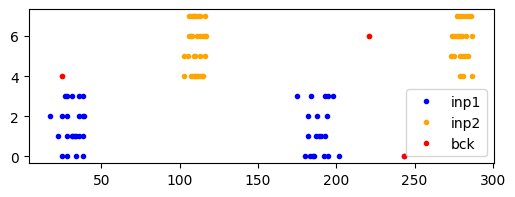

In [603]:
plt.figure(figsize = (6, 2))
plt.plot(inputLayer1['spike.t', 0], inputLayer1['spike.i', 0], '.', color = "blue")
# plt.plot(inputLayerMiddle['spike.t', 0], inputLayerMiddle['spike.i', 0] + 3, '.', color = "purple")
plt.plot(inputLayer2['spike.t', 0], inputLayer2['spike.i', 0] + 4, '.', color = "orange")
# plt.plot(inputLayerIsolated['spike.t', 0] + 4, inputLayerIsolated['spike.i', 0] + 8, '.', color = "green")

plt.plot(inputLayer1['bck_spike.t', 0], inputLayer1['bck_spike.i', 0], '.', color = "red")
# plt.plot(inputLayerMiddle['spike.t', 0], inputLayerMiddle['spike.i', 0] + 3, '.', color = "purple")
plt.plot(inputLayer2['bck_spike.t', 0], inputLayer2['bck_spike.i', 0] + 4, '.', color = "red")
# plt.plot(inputLayerIsolated['bck_spike.t', 0] + 4, inputLayerIsolated['bck_spike.i', 0] + 8, '.', color = "red")

plt.legend(["inp1","inp2", "bck"])

In [604]:
# # plt.figure(figsize = (6, 2))

# plt.plot(inputLayer1['spike.t', 0], inputLayer1['spike.i', 0], '.', color = "blue")
# plt.xlabel('iterations')
# plt.ylabel('neuron index')
# plt.title('Raster Plot')
# plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_8956\2961636470.py:2: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(outputLayer['spike.t', 0], outputLayer['spike.i', 0], '.', color = "blue", marker = "|", markersize = 20, markeredgewidth=1.4)
C:\Users\Asus\AppData\Local\Temp\ipykernel_8956\2961636470.py:3: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(outputLayer['bck_spike.t', 0], outputLayer['bck_spike.i', 0], '.', color = "orange", marker = "|", markersize = 20, markeredgewidth=1.4)


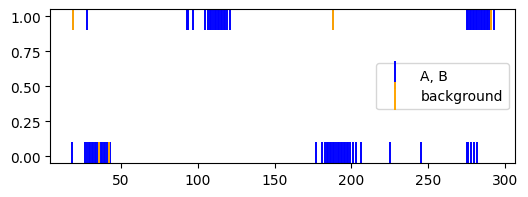

In [605]:
plt.figure(figsize = (6, 2))
plt.plot(outputLayer['spike.t', 0], outputLayer['spike.i', 0], '.', color = "blue", marker = "|", markersize = 20, markeredgewidth=1.4)
plt.plot(outputLayer['bck_spike.t', 0], outputLayer['bck_spike.i', 0], '.', color = "orange", marker = "|", markersize = 20, markeredgewidth=1.4)
# plt.plot(outputLayerIsolated['spike.t', 0] + 2, outputLayerIsolated['spike.i', 0] + 2, '.', color = "orange", marker = "|", markersize = 20, markeredgewidth=1.4)
plt.legend(["A, B", "background"])

tensor([[52.6632, 20.8331],
        [49.7963, 19.3262],
        [55.9123, 18.4333],
        [60.0000, 11.3518]])


Text(0.5, 1.0, 'Weight changes')

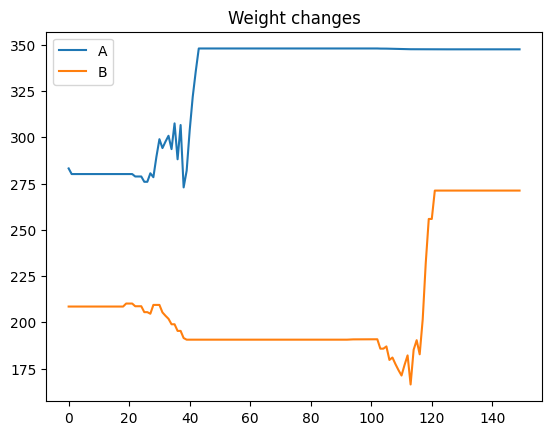

In [608]:
print(syn1['W', 0][99])
# print(syn2['W', 0][99])

plt.plot(torch.sum(syn2['W', 0][:150], axis = 1) + torch.sum(syn1['W', 0][:150], axis = 1) + torch.sum(syn3['W', 0][:150], axis = 1))
# plt.plot(torch.sum(syn2_iso['W', 0], axis = 1) + torch.sum(syn1_iso['W', 0], axis = 1) + torch.sum(syn3_iso['W', 0], axis = 1))
plt.legend(["A", "B"])
plt.title("Weight changes")

torch.Size([300, 8])


Text(0.5, 1.0, 'Cosine Similarity')

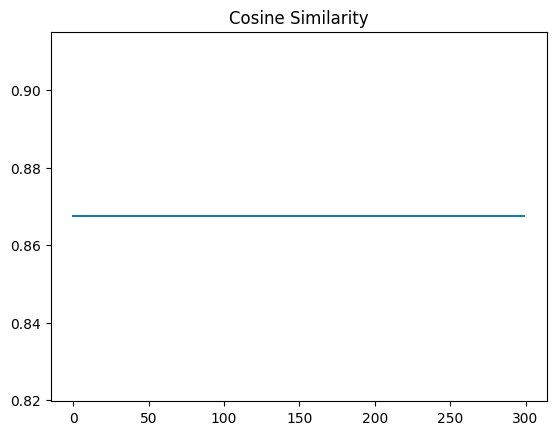

In [658]:
base = torch.cat((syn1['W', 0], syn2['W', 0], syn3['W', 0]), dim = 1)
# baseIso = torch.cat((syn1_iso['W', 0], syn2_iso['W', 0], syn3_iso['W', 0]), dim = 1)
A = base[:,:,0]
B = base[:,:,1]
# iso = baseIso[:,:,0]

plt.plot(torch.nn.functional.cosine_similarity(A, B, dim = 1))
# plt.plot(torch.nn.functional.cosine_similarity(B, iso, dim = 1))
plt.title("Cosine Similarity")
# plt.legend(["A-ISO", "B-ISO"])

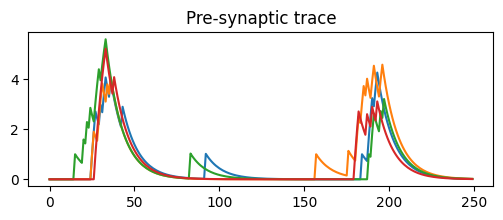

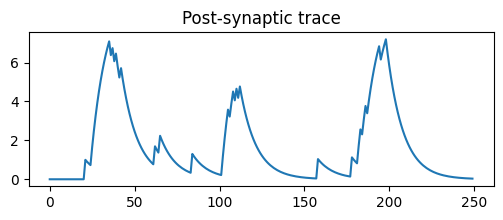

In [469]:
plt.figure(figsize = (6, 2))
plt.plot(inputLayer1['x_trace', 0][:,])
plt.title("Pre-synaptic trace")
plt.show()
plt.figure(figsize = (6, 2))
plt.title("Post-synaptic trace")
plt.plot(outputLayer['y_trace', 0][:,0])

# Background Activity

In [204]:
class BackgroundActivity(Behavior) : 

    def initialize(self, ng) : 
        self.rate = self.parameter("rate", 0.005)
        ng.bck_spike = ng.vector("zeros")

    def forward(self, ng) : 
        a = torch.rand(ng.size)
        ng.bck_spike = a <= self.rate
        ng.spike[a <= self.rate] = 1

In [44]:
pre = torch.tensor([1, 2, 3])
post = torch.tensor([0, 10])

# print(post[:, None])
print(pre[:,None] * post) 
# (post[:, None] * pre[None, :])[0].T

tensor([[ 0, 10],
        [ 0, 20],
        [ 0, 30]])


In [34]:
a = torch.tensor([1, 2, 3])
b = a.clone()
a[0] = 5
b

tensor([1, 2, 3])

In [77]:
net = Network()

inputLayer = NeuronGroup(net = net, size = 1024, behavior={
    2 : PoissionEncoding(input = ImagePipeline("data/bird.tif"), T = 30, lamda = 0.0001),   
    10 : EventRecorder(['spike']) 
})

mainLayer = NeuronGroup(net = net, size = 10, behavior={
    4 : SynTypeInput(),
    6 : LIF_Behavior(tau = 15),
    7 : Flat_STDP(),
    9 : Recorder(['voltage', 'torch.mean(voltage)', 'I', 'activity']),
    10 : EventRecorder(['spike'])
})

outputLayer = NeuronGroup(net = net, size = 2, behavior={
    4 : SynTypeInput(),
    6 : LIF_Behavior(tau = 15),
    7 : Flat_STDP(stdp_factor = 0.04),
    9 : Recorder(['voltage', 'torch.mean(voltage)', 'I', 'activity']),
    10 : EventRecorder(['spike'])
})


SynapseGroup(net = net, src = inputLayer, dst = mainLayer, tag = "GLUTAMATE", behavior={
    2 : SynConnectivity(mode = "full", J0 = 10),
    3 : SynFun()
})

final_sg = SynapseGroup(net = net, src = mainLayer, dst = outputLayer, tag = "GLUTAMATE", behavior={
    2 : SynConnectivity(mode = "full", J0 = 15),
    3 : SynFun(),
    9 : Recorder(['W']),
})

In [78]:
net.initialize()
net.simulate_iterations(100)

Network['Network'](Neurons: tensor(1036)|3 groups, Synapses: tensor(10260)|2 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1024){2:PoissionEncoding(input=tensor([187, 192, 192,  ..., 105,  85,  72]),T=30,lamda=0.0001,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](10){4:SynTypeInput()6:LIF_Behavior(tau=15,)7:Flat_STDP()9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I', 'activity'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
NeuronGroup['NeuronGroup_3', 'NeuronGroup', 'ng'](2){4:SynTypeInput()6:LIF_Behavior(tau=15,)7:Flat_STDP(stdp_factor=0.04,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I', 'activity'],)10:EventRecorder(variables=None,gap_width=0,

C:\Users\Asus\AppData\Local\Temp\ipykernel_25816\430882707.py:8: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  sg.I = torch.sum(sg.W[sg.src.spike], axis = 0)


100xBatch: 1/1 (100%) 196.513ms


196.51341438293457

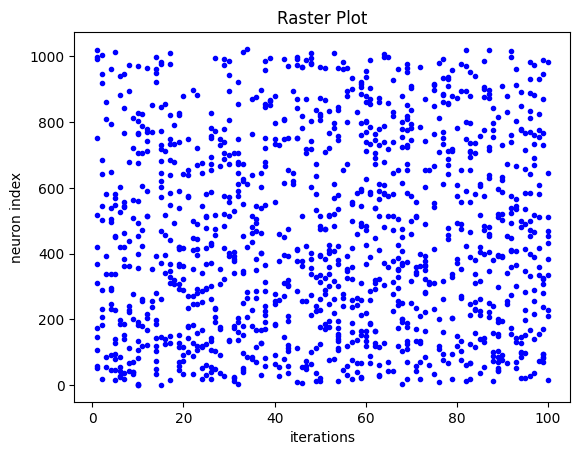

In [79]:
plt.plot(inputLayer['spike.t', 0], inputLayer['spike.i', 0], '.', color = "blue")
plt.xlabel('iterations')
plt.ylabel('neuron index')
plt.title('Raster Plot')
plt.show()

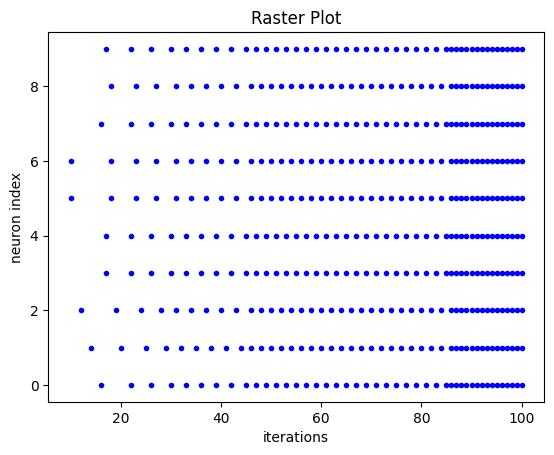

In [38]:
plt.plot(mainLayer['spike.t', 0], mainLayer['spike.i', 0], '.', color = "blue")
plt.xlabel('iterations')
plt.ylabel('neuron index')
plt.title('Raster Plot')
plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_25816\2170543954.py:2: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(outputLayer['spike.t', 0], outputLayer['spike.i', 0], '.', color = "blue", marker = "|", markersize = 20, markeredgewidth=1.4)


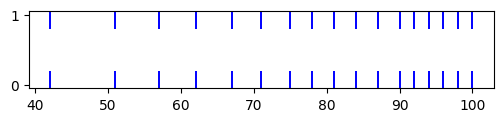

In [39]:
plt.figure(figsize = (6, 1))
plt.plot(outputLayer['spike.t', 0], outputLayer['spike.i', 0], '.', color = "blue", marker = "|", markersize = 20, markeredgewidth=1.4)

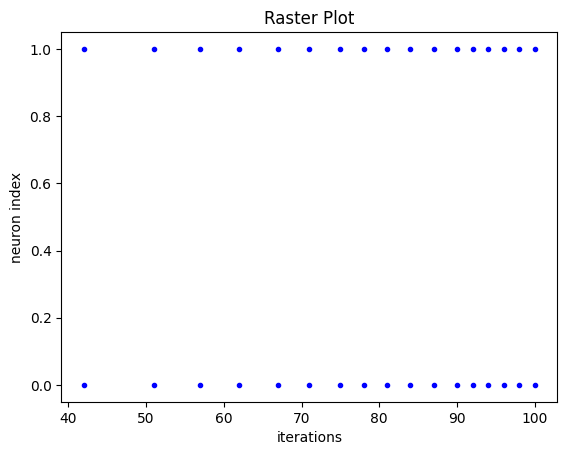

In [40]:
plt.plot(outputLayer['spike.t', 0], outputLayer['spike.i', 0], '.', color = "blue")
plt.xlabel('iterations')
plt.ylabel('neuron index')
plt.title('Raster Plot')
plt.show()

In [41]:
final_sg['W', 0].shape

torch.Size([100, 10, 2])

# Flat-R-STDP

In [42]:
class Flat_R_STDP(Behavior) : 

    def initialize(self, ng) :
        self.stdp_factor = self.parameter("stdp_factor", 0.015)
        self.syn_type = self.parameter("syn_type", "GLUTAMATE")


        # Reinforcement Learning
        self.da = self.parameter("da", None)


        ng.spike_train = ng.vector("zeros")

    def forward(self, ng) : 
        
        for syn in ng.afferent_synapses[self.syn_type] : 

            pre_post = syn.dst.spike[:, None] * syn.src.spike_train[None, :]
            post_pre = syn.dst.spike_train[:, None] * syn.src.spike[None, :]

            dW_neg = self.stdp_factor * (post_pre)
            dW_pos = self.stdp_factor * (pre_post)

            syn.W -= dW_neg.T
            syn.W += dW_pos.T
        
        ng.spike_train = ng.spike.clone()

# Experiment

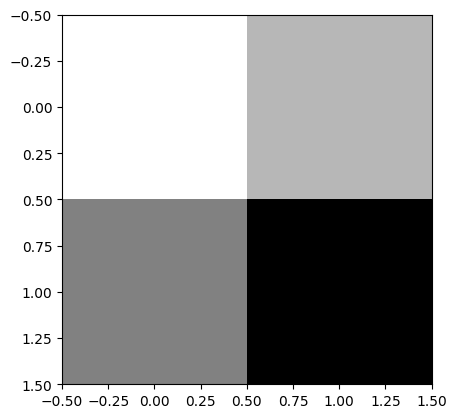

tensor([154, 134, 119,  83])

In [43]:
ImagePipeline("data/bird.tif", shape = (2, 2), show = True)

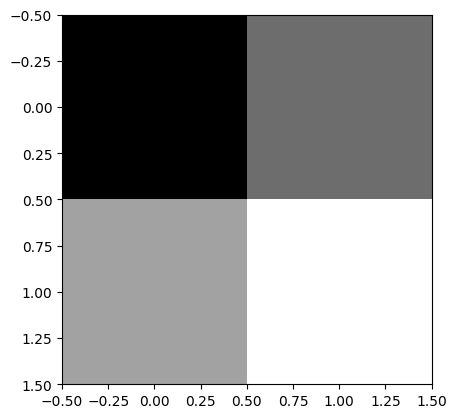

tensor([ 70,  97, 110, 133])

In [44]:
ImagePipeline("data/circles.tif", shape = (2, 2), show = True)

In [260]:
net = Network()

inputLayer1 = NeuronGroup(net = net, size = 4, behavior={
    2 : PoissionEncoding(input = ImagePipeline("data/bird.tif", shape = (2, 2)), T = 0, lamda = 0.002),
    # 3 : CurrentBehavior(mode = "random", pw = 3),
    10 : EventRecorder(['spike']) 
})

inputLayer2 = NeuronGroup(net = net, size = 4, behavior={
    2 : PoissionEncoding(input = ImagePipeline("data/bird.tif", shape = (2, 2)), T = 50, lamda = 0.002),   
    # 3 : CurrentBehavior(mode = "random", pw = 3),
    10 : EventRecorder(['spike']) 
})

outputLayer = NeuronGroup(net = net, size = 2, behavior={
    3 : CurrentBehavior(mode = "random", pw = 0.1),
    4 : SynTypeInput(),
    6 : LIF_Behavior(tau = 15),
    7 : Flat_STDP(stdp_factor = 0.7),
    9 : Recorder(['voltage', 'torch.mean(voltage)', 'I', 'activity']),
    10 : EventRecorder(['spike'])
})


syn1 = SynapseGroup(net = net, src = inputLayer1, dst = outputLayer, tag = "GLUTAMATE", behavior={
    2 : SynConnectivity(mode = "full", J0 = 4),
    3 : SynFun(),
    9 : Recorder(['W']),
})

syn2 = SynapseGroup(net = net, src = inputLayer2, dst = outputLayer, tag = "GLUTAMATE", behavior={
    2 : SynConnectivity(mode = "full", J0 = 4),
    3 : SynFun(),
    9 : Recorder(['W']),
})

In [261]:
net.initialize()
net.simulate_iterations(100)

Network['Network'](Neurons: tensor(10)|3 groups, Synapses: tensor(16)|2 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](4){2:PoissionEncoding(input=tensor([154, 134, 119,  83]),T=0,lamda=0.002,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](4){2:PoissionEncoding(input=tensor([154, 134, 119,  83]),T=50,lamda=0.002,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
NeuronGroup['NeuronGroup_3', 'NeuronGroup', 'ng'](2){3:CurrentBehavior(mode=random,pw=0.1,)4:SynTypeInput()6:LIF_Behavior(tau=15,)7:Flat_STDP(stdp_factor=0.7,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I', 'activity'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
SynapseGroup['GLUTAMATE', 'SynapseGroup', 'syn',

100xBatch: 1/1 (100%) 537.022ms


537.0218753814697

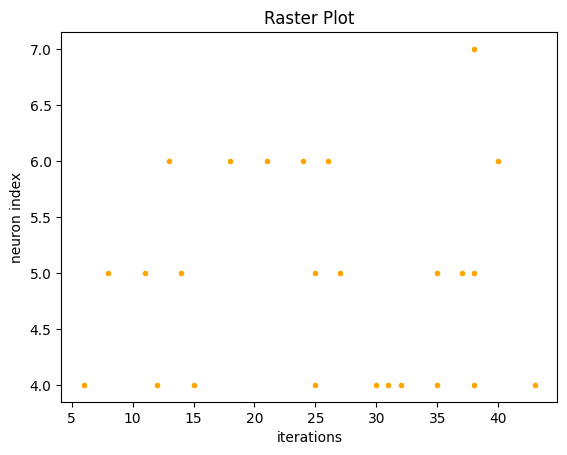

In [262]:
plt.plot(inputLayer1['spike.t', 0], inputLayer1['spike.i', 0], '.', color = "blue")
plt.plot(inputLayer2['spike.t', 0], inputLayer2['spike.i', 0] + 4, '.', color = "orange")
plt.xlabel('iterations')
plt.ylabel('neuron index')
plt.title('Raster Plot')
plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_25816\552943669.py:2: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(outputLayer['spike.t', 0], outputLayer['spike.i', 0], '.', color = "blue", marker = "|", markersize = 20, markeredgewidth=1.4)


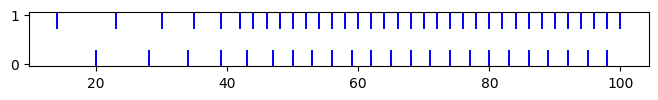

In [318]:
plt.figure(figsize = (8, 0.7))
plt.plot(outputLayer['spike.t', 0], outputLayer['spike.i', 0], '.', color = "blue", marker = "|", markersize = 20, markeredgewidth=1.4)

# Weight Changes

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]])


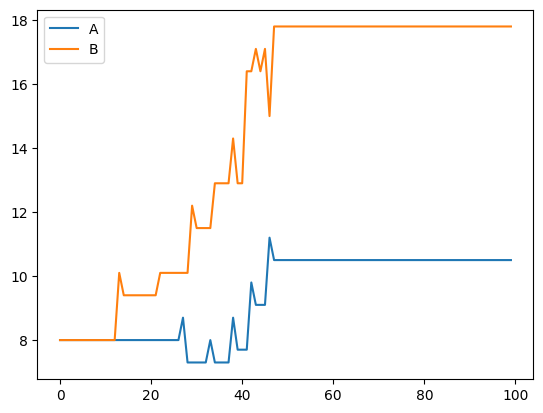

In [319]:
print(syn1['W', 0][99])
# print(syn2['W', 0][99])

plt.plot(torch.sum(syn2['W', 0], axis = 1) + torch.sum(syn1['W', 0], axis = 1))
plt.legend(["A", "B"])

# Cosine Similarity

In [320]:
A = (syn1['W', 0][99] + syn2['W', 0][99])[:,0]
B = (syn1['W', 0][99] + syn2['W', 0][99])[:,1]
torch.nn.functional.cosine_similarity(A, B, dim = 0).item()

0.8937908411026001

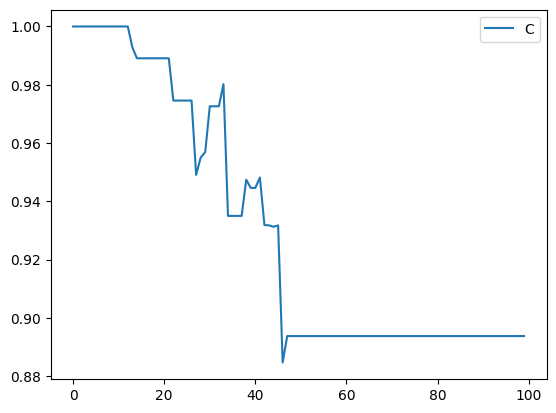

In [322]:
A = (syn1['W', 0] + syn2['W', 0])[:,:,0]
B = (syn1['W', 0] + syn2['W', 0])[:,:,1]

plt.plot(torch.nn.functional.cosine_similarity(A, B, dim = 1))
plt.legend("CosineSimilarity")

# R-STDP

In [625]:
class R_STDP(Behavior) : 

    def initialize(self, ng) : 
        self.r_stdp_factor = self.parameter("r_stdp_factor", 0.5)
        self.syn_type = self.parameter("syn_type", "GLUTAMATE")

    def forward(self, ng) :
        
        for syn in ng.afferent_synapses[self.syn_type] : 

            dW =  (syn.elig_trace * ng.network.dop) * ng.network.dt
            syn.W = torch.clip(syn.W + dW, 0.0, 60.0)

In [962]:
class RewardFunction(Behavior) :

    def initialize(self, ng) : 
        ng.network.dop = 0
        self.tau_d = self.parameter("tau_d", 30)

        self.reward = self.parameter("reward", 6)
        self.punish = self.parameter("punish", -2)

        self.offset = self.parameter("offset", required = True)
        self.T = self.parameter("T", required = True)
        self.target = self.parameter("target", required = True)

    def forward(self, ng) : 
        dD = -ng.network.dop/self.tau_d + self.DA(ng)
        ng.network.dop += dD * ng.network.dt

    def DA(self, ng) : 
        pat = self.pattern(ng)
        if(pat == -1) : 
            return 0
        
        if(ng.spike[ng.spike == 1].size()[0] == 1 and ng.spike[self.target[pat]] == 1) : 
            return self.reward
        elif(ng.spike[ng.spike == 1].size()[0] != 0) : 
            return self.punish
        return 0

    def pattern(self, ng) : 
        for i in range(len(self.offset)) : 
            if(ng.network.iteration >= self.offset[i] and ng.network.iteration - self.offset[i] <= self.T[i]) : 
                return i
        return -1

In [1576]:
class EligTrace(Behavior) : 

    def initialize(self, sg) : 
        
        self.tau_c = self.parameter("tau_c", 30)
        self.factor = self.parameter("factor", 0.005)
        sg.elig_trace = sg.matrix("zeros")

    def forward(self, sg) : 
        
        dTrace = -sg.elig_trace/self.tau_c + self.deltaW(sg)
        sg.elig_trace += dTrace * sg.network.dt

    def deltaW(self, sg) : 

        post_pre = self.factor * sg.dst.y_trace * sg.src.spike[:, None]
        pre_post = self.factor * sg.src.x_trace[:,None] * sg.dst.spike

        dW =  (-post_pre + pre_post) * sg.network.dt
        return dW

In [1577]:
class R_STDP(Behavior) : 

    def initialize(self, ng) : 

        ng.dp = ng.vector("zeros")
        self.syn_type = self.parameter("syn_type", "GLUTAMATE")
        self.test_phase = self.parameter("test_phase", 160)

    def forward(self, ng) : 

        if(ng.network.iteration >= self.test_phase) : 
            return

        ng.dp = ng.vector(ng.network.dop)
        
        for syn in ng.afferent_synapses[self.syn_type] : 
            
            dW = syn.elig_trace * ng.network.dop
            syn.W = torch.clip(syn.W + dW, 0.0, 60.0)

In [1578]:
class InitialSpike(Behavior) : 

    def initialize(self, ng) : 
        
        self.offset = self.parameter("offset", required = True)
        self.T = self.parameter("T", required = True)
        self.target = self.parameter("target", required = True)
        self.rate = self.parameter("rate", 0.4)
    
    def forward(self, ng) : 
        pat = self.pattern(ng)
        if(pat == -1) : 
            return

        ng.spike[self.target[pat]] |= random.random() <= self.rate

    def pattern(self, ng) : 
        for i in range(len(self.offset)) : 
            if(ng.network.iteration >= self.offset[i] and ng.network.iteration - self.offset[i] <= self.T[i]) : 
                return i
        return -1

# Experiment (2)

In [1663]:
net = Network(behavior={1 : TimeResolution(dt = 1)})

inputLayer1 = NeuronGroup(net = net, size = 4, behavior={
    # 2 : PoissionEncoding(input = ImagePipeline("data/bird.tif", shape = (2, 2)), T = 0, lamda = 0.002),
    2 : PoissionGenerator(offset = [0, 80, 400], T = [60, 60, 60], lamda = [30, 30, 30]),
    # 3 : BackgroundActivity(),
    # 3 : CurrentBehavior(mode = "random", pw = 3),
    7 : Trace(),
    
    20 : Recorder(['x_trace','y_trace']),
    21 : EventRecorder(['spike'])
})

# inputLayerMiddle = NeuronGroup(net = net, size = 0, behavior={
#     # 2 : PoissionEncoding(input = ImagePipeline("data/bird.tif", shape = (2, 2)), T = 50, lamda = 0.002),   
#     2 : PoissionGenerator(offset = [0, 80, 160, 250, 400, 450], T = [60, 60, 60, 60, 60, 60], lamda = [30, 30, 30, 30, 30, 30]),
#     3 : BackgroundActivity(),
#     # 3 : CurrentBehavior(mode = "random", pw = 3),
#     7 : Trace(),

#     20 : Recorder(['x_trace','y_trace']),
#     21 : EventRecorder(['spike', 'bck_spike']) 
# })

inputLayer2 = NeuronGroup(net = net, size = 4, behavior={
    # 2 : PoissionEncoding(input = ImagePipeline("data/bird.tif", shape = (2, 2)), T = 50, lamda = 0.002),   
    2 : PoissionGenerator(offset = [160, 250, 450], T = [60, 60, 60], lamda = [30, 30, 30]),
    # 3 : BackgroundActivity(),
    # 3 : CurrentBehavior(mode = "random", pw = 3),
    7 : Trace(),

    20 : Recorder(['x_trace','y_trace']),
    21 : EventRecorder(['spike']) 
})


# --------------------------------- ISOLATED NEURONS --------------------------------------------------

# inputLayerIsolated = NeuronGroup(net = net, size = 1, behavior={
#     # 2 : PoissionEncoding(input = ImagePipeline("data/bird.tif", shape = (2, 2)), T = 50, lamda = 0.002),   
#     2 : PoissionGenerator(offset = [0], T = [0], lamda = [0]),
#     3 : BackgroundActivity(),
#     # 3 : CurrentBehavior(mode = "random", pw = 3),
#     7 : Trace(),

#     9 : Recorder(['x_trace','y_trace']),
#     10 : EventRecorder(['spike', 'bck_spike']) 
# })

# outputLayerIsolated = NeuronGroup(net = net, size = 1, behavior={
#     # 3 : CurrentBehavior(mode = "random", pw = 0.1),
#     4 : SynTypeInput(),
#     6 : LIF_Behavior(tau = 15, threshold = 10000),
#     7 : BackgroundActivity(0.1),
    
#     10 : Trace(),
#     12 : RewardFunction(target = [0, 0, 0, 0], offset = [0, 80, 160, 250], T = [60, 60, 60, 60], reward = 2, punish = -4),
#     13 : R_STDP(test_phase = 320),

#     20 : Recorder(['voltage', 'torch.mean(voltage)', 'I', 'activity', 'x_trace','y_trace']),
#     21 : EventRecorder(['spike', 'bck_spike']) 
# })


# --------------------------------- ISOLATED NEURONS --------------------------------------------------

outputLayer = NeuronGroup(net = net, size = 2, behavior={
    # 3 : CurrentBehavior(mode = "random", pw = 0.1),
    4 : SynTypeInput(),
    6 : LIF_Behavior(tau = 15),
    # 7 : BackgroundActivity(0.1),
    # 8 : Bias(target = 2, offset = 90, T = 10),
    # 9 : LateralInhibition(inh_rate = 180),
    9 : InitialSpike(target = [0, 1, 1, 0], offset = [0, 40, 160, 200], T = [20, 20, 20, 20]),
    
    10 : Trace(),
    12 : RewardFunction(target = [0, 0, 1, 1], offset = [0, 80, 160, 250], T = [60, 60, 60, 60], reward = 4, punish = -70),
    13 : R_STDP(test_phase = 320),

    20 : Recorder(['voltage', 'torch.mean(voltage)', 'I', 'activity', 'x_trace','y_trace', 'dp']),
    21 : EventRecorder(['spike']) 
})


syn1 = SynapseGroup(net = net, src = inputLayer1, dst = outputLayer, tag = "GLUTAMATE", behavior={
    2 : SynConnectivity(mode = "full2", J0 = 10),
    3 : SynFun(),
    
    11 : EligTrace(),

    20 : Recorder(['W', 'elig_trace']),
})

syn2 = SynapseGroup(net = net, src = inputLayer2, dst = outputLayer, tag = "GLUTAMATE", behavior={
    2 : SynConnectivity(mode = "full2", J0 = 10),
    3 : SynFun(),
    
    11 : EligTrace(),

    20 : Recorder(['W', 'elig_trace']),
})

# syn3 = SynapseGroup(net = net, src = inputLayerMiddle, dst = outputLayer, tag = "GLUTAMATE", behavior={
#     2 : SynConnectivity(mode = "full2", J0 = 10),
#     3 : SynFun(),

#     11 : EligTrace(),

#     20 : Recorder(['W', 'elig_trace']),
# })

# --------------------------------- ISOLATED NEURONS --------------------------------------------------

# syn1_iso = SynapseGroup(net = net, src = inputLayer1, dst = outputLayerIsolated, tag = "GLUTAMATE", behavior={
#     2 : SynConnectivity(mode = "full2", J0 = 2),
#     3 : SynFun(),

#     11 : EligTrace(),

#     20 : Recorder(['W']),
# })

# syn2_iso = SynapseGroup(net = net, src = inputLayer2, dst = outputLayerIsolated, tag = "GLUTAMATE", behavior={
#     2 : SynConnectivity(mode = "full2", J0 = 2),
#     3 : SynFun(),

#     11 : EligTrace(),

#     20 : Recorder(['W']),
# })

# syn3_iso = SynapseGroup(net = net, src = inputLayerMiddle, dst = outputLayerIsolated, tag = "GLUTAMATE", behavior={
#     2 : SynConnectivity(mode = "full2", J0 = 2),
#     3 : SynFun(),

#     11 : EligTrace(),

#     20 : Recorder(['W']),
# })

# syn4_iso = SynapseGroup(net = net, src = inputLayerIsolated, dst = outputLayerIsolated, tag = "GLUTAMATE", behavior={
#     2 : SynConnectivity(mode = "full2", J0 = 2),
#     3 : SynFun(),

#     11 : EligTrace(),

#     20 : Recorder(['W']),
# })

# syn5_iso = SynapseGroup(net = net, src = inputLayerIsolated, dst = outputLayer, tag = "GLUTAMATE", behavior={
#     2 : SynConnectivity(mode = "full2", J0 = 2),
#     3 : SynFun(),

#     11 : EligTrace(),

#     20 : Recorder(['W']),
# })

# --------------------------------- ISOLATED NEURONS --------------------------------------------------

In [1664]:
net.initialize()
net.simulate_iterations(500)

Network['Network'](Neurons: tensor(10)|3 groups, Synapses: tensor(16)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](4){2:PoissionGenerator(offset=[0, 80, 400],T=[60, 60, 60],lamda=[30, 30, 30],)7:Trace()20:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['x_trace', 'y_trace'],)21:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](4){2:PoissionGenerator(offset=[160, 250, 450],T=[60, 60, 60],lamda=[30, 30, 30],)7:Trace()20:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['x_trace', 'y_trace'],)21:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
NeuronGroup['NeuronGroup_3', 'NeuronGroup', 'ng'](2){4:SynTypeInput()6:LIF_Behavior(tau=15,)9:InitialSpike(target=[0, 1, 1, 0],offset=[0, 40, 160, 200],T=[20, 20, 20, 20],)10:Tra

C:\Users\Asus\AppData\Local\Temp\ipykernel_8956\1254274051.py:22: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  self.poisson = (np.exp(-self.lamda[pat]) * (self.lamda[pat] ** (ng.network.iteration - self.offset[pat]))) / (np.math.factorial(ng.network.iteration - self.offset[pat])) / ((np.exp(-self.lamda[pat]) * (self.lamda[pat] ** self.lamda[pat])) / (np.math.factorial(self.lamda[pat]))*2)


500xBatch: 1/1 (100%) 1188.857ms


1188.857078552246

Text(0.5, 1.0, 'Input layer raster plot')

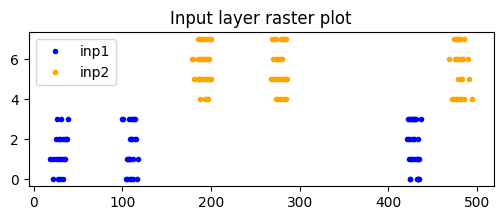

In [1665]:
plt.figure(figsize = (6, 2))
plt.plot(inputLayer1['spike.t', 0], inputLayer1['spike.i', 0], '.', color = "blue")
# plt.plot(inputLayerMiddle['spike.t', 0], inputLayerMiddle['spike.i', 0] + 2, '.', color = "purple")
plt.plot(inputLayer2['spike.t', 0], inputLayer2['spike.i', 0] + 4, '.', color = "orange")
# plt.plot(inputLayerIsolated['spike.t', 0] + 8, inputLayerIsolated['spike.i', 0] + 8, '.', color = "green")

# plt.plot(inputLayer1['bck_spike.t', 0], inputLayer1['bck_spike.i', 0], '.', color = "red")
# plt.plot(inputLayerMiddle['spike.t', 0], inputLayerMiddle['spike.i', 0] + 3, '.', color = "purple")
# plt.plot(inputLayer2['bck_spike.t', 0], inputLayer2['bck_spike.i', 0] + 4, '.', color = "red")
# plt.plot(inputLayerIsolated['bck_spike.t', 0] + 4, inputLayerIsolated['bck_spike.i', 0] + 8, '.', color = "red")

plt.legend(["inp1", "inp2"])
plt.title("Input layer raster plot")

C:\Users\Asus\AppData\Local\Temp\ipykernel_8956\560178110.py:2: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(outputLayer['spike.t', 0], outputLayer['spike.i', 0], '.', color = "blue", marker = "|", markersize = 20, markeredgewidth=1.4)
d:\Program Files\Anaconda\envs\myenv\Lib\site-packages\IPython\core\displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


Text(0.5, 1.0, 'Output layer raster plot')

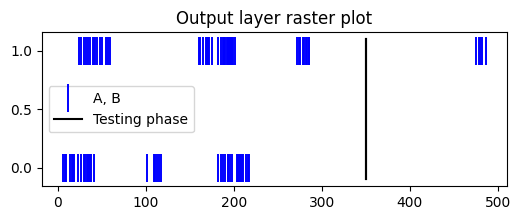

In [1666]:
plt.figure(figsize = (6, 2))
plt.plot(outputLayer['spike.t', 0], outputLayer['spike.i', 0], '.', color = "blue", marker = "|", markersize = 20, markeredgewidth=1.4)
plt.plot([350, 350], [-0.1, 1.1], color = "black")
# plt.plot(outputLayer['bck_sNpike.t', 0], outputLayer['bck_spike.i', 0], '.', color = "orange", marker = "|", markersize = 20, markeredgewidth=1.4)
# plt.plot(outputLayerIsolated['spike.t', 0] + 2, outputLayerIsolated['spike.i', 0] + 2, '.', color = "orange", marker = "|", markersize = 20, markeredgewidth=1.4)
plt.plot([350, 350], [-0.1, 1.1], color = "black")

plt.legend(["A, B","Testing phase"])
plt.title("Output layer raster plot")

Text(0.5, 1.0, 'Dopamine Rate')

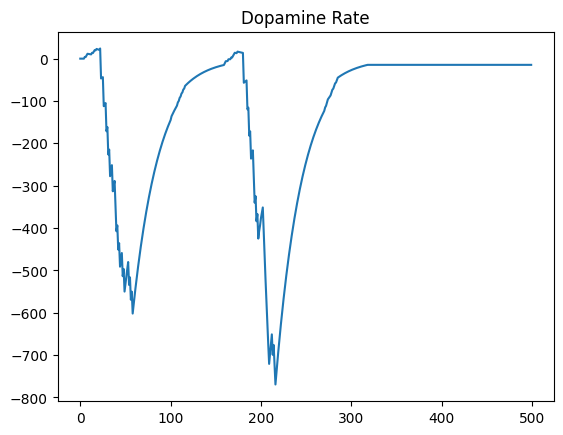

In [1671]:
plt.plot(net["dp", 0][:,0])
plt.title("Dopamine Rate")

Text(0.5, 1.0, 'Cosine Similarity')

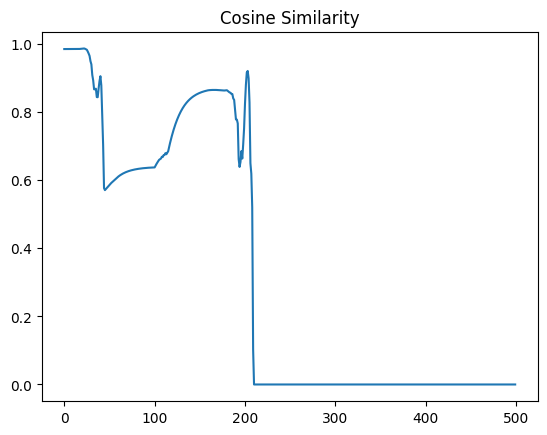

In [1668]:
base = torch.cat((syn1['W', 0], syn2['W', 0], syn3['W', 0]), dim = 1)
# baseIso = torch.cat((syn1_iso['W', 0], syn2_iso['W', 0], syn3_iso['W', 0], syn4_iso['W', 0]), dim = 1)
A = base[:,:,0]
B = base[:,:,1]

# iso = baseIso[:,:,0]

plt.plot(torch.nn.functional.cosine_similarity(A, B, dim = 1))
# plt.plot(torch.nn.functional.cosine_similarity(B, iso, dim = 1))
plt.title("Cosine Similarity")
# plt.legend(["A-ISO", "B-ISO"])

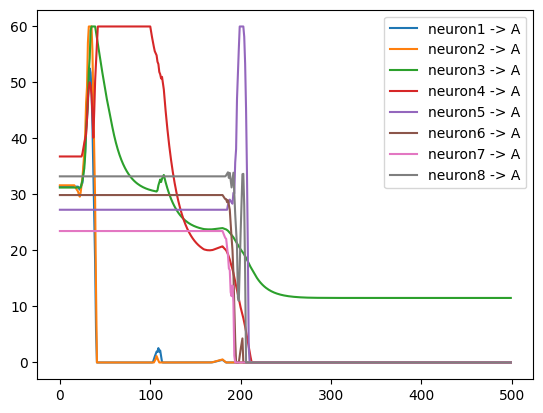

In [1669]:
plt.plot(A)
plt.legend(["neuron{} -> A".format(i + 1) for i in range(8)] + ["isoalted"])
plt.show()

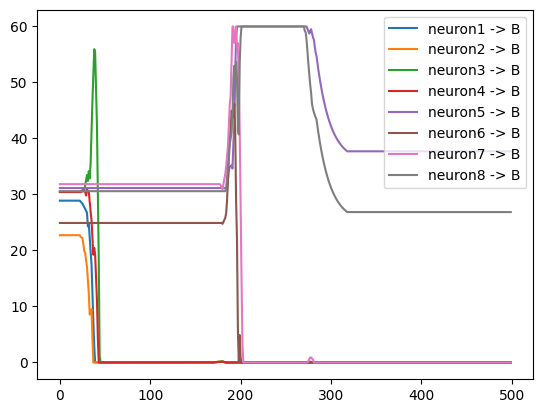

In [1670]:
plt.plot(B)
plt.legend(["neuron{} -> B".format(i + 1) for i in range(8)])
plt.show()